# Traffic prediction with Pytorch

## Librairies

In [1]:
# Helper librairies
import os
import numpy as np
import pandas as pd
import random as rd
from datetime import datetime, date

# Torch
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.utils.data

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns # prettier plots

## The data

In [2]:
data_path = os.getcwd() + "/"

train=pd.read_csv(data_path + "Radar_Traffic_Counts.csv")
raw_traffic = train[:]

#### The relative location of roads

In [3]:
absolute_loc = pd.DataFrame(train.groupby(['location_name','location_latitude','location_longitude'])['Volume'].sum()).reset_index()

lat_min = absolute_loc["location_latitude"].min()
lat_max = absolute_loc["location_latitude"].max()
long_min = absolute_loc["location_longitude"].min()
long_max = absolute_loc["location_longitude"].max()

relative_loc = absolute_loc[['location_name','location_latitude','location_longitude']]
relative_loc = relative_loc.sort_values(by=['location_name'], ascending=True)

relative_loc["location_latitude"] = ( absolute_loc["location_latitude"] - lat_min ) / ( lat_max - lat_min )
relative_loc["location_longitude"] = ( absolute_loc["location_longitude"] - long_min ) / ( long_max - long_min )

## Average by day

In [4]:
dates_days = pd.DataFrame({'year': raw_traffic["Year"],'month': raw_traffic["Month"],'day': raw_traffic["Day"]})
dates_days = pd.to_datetime(dates_days)
traffic_per_day  = pd.DataFrame(list(zip(raw_traffic['location_name'],dates_days,raw_traffic['Volume'])))
traffic_per_day.columns = ['location_name','Date','Volume']
traffic_per_day = pd.DataFrame(traffic_per_day.groupby(['location_name','Date'])['Volume'].mean()).reset_index()

## Complete the data per day

In [5]:
byLocation=traffic_per_day.groupby(["location_name"])
location_volumes = [byLocation.get_group(x) for x in byLocation.groups]

In [6]:
for i in range(len(location_volumes)):
    location_volumes[i] = location_volumes[i].set_index("Date")
    start = location_volumes[i].index[0]
    end = location_volumes[i].index[-1]
    full_range = pd.date_range(start=start, end=end)
    location_volumes[i] = location_volumes[i].reindex(full_range).fillna(0)

In [7]:
# print(location_volumes[0])
# plt.plot(location_volumes[0]["Volume"])

# for i in range(len(location_volumes)):
#     print(i,np.around(location_volumes[i]["Volume"],2)[:7])

# print(np.around(location_volumes[15]["Volume"],2)[:25])
# plt.plot(location_volumes[7]["Volume"],'go')

In [8]:
# On enlève les routes mal représentés et on remplie les trous de la première semaine à la main
location_volumes[5]["Volume"][1] = 52
location_volumes[7]["Volume"][6] = 21
location_volumes[8]["Volume"][5] = 42
location_volumes[8]["Volume"][6] = 42
location_volumes[9]["Volume"][5] = 32
location_volumes[9]["Volume"][6] = 32
location_volumes[15]["Volume"][5] = 33
location_volumes[15]["Volume"][6] = 33
location_volumes = location_volumes[:18]
location_volumes = location_volumes[:15]+location_volumes[16:]

In [9]:
for i in range(len(location_volumes)):
    for j in range(7,len(location_volumes[i]["Volume"])):
        if location_volumes[i]["Volume"][j] == 0 :
            location_volumes[i]["Volume"][j] = np.mean([location_volumes[i]["Volume"][j-7],location_volumes[i]["Volume"][j-1]])
    location_volumes[i]["Volume"] = np.around(location_volumes[i]["Volume"],2)

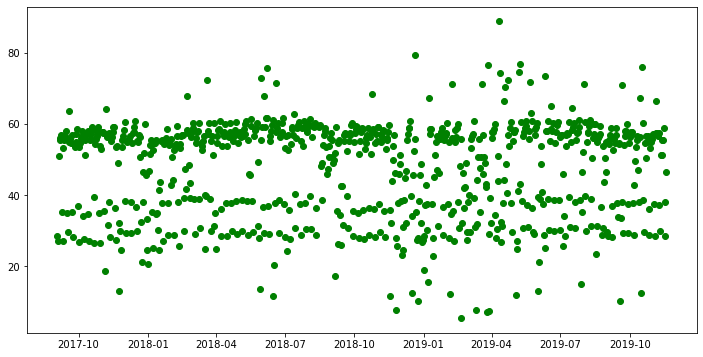

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(location_volumes[0]["Volume"],'go')
plt.savefig('images/after1.png')

## Dataset à partir de la méthode sliding window

In [85]:
# Création du dataset final pour la prédiction journalière
dataset = []
sliding_window = 60 # on prend les 60 derniers jours
for i in range(len(location_volumes)):
    serie = np.array(location_volumes[i]["Volume"])
    for j in range(len(serie)-sliding_window):
        sample = serie[j:j+sliding_window]/max(serie[j:j+sliding_window])
        label = serie[j+sliding_window]/max(serie[j:j+sliding_window])
        dataset.append(np.array([sample, label]))

dataset = np.array(dataset)
np.random.shuffle(dataset)
data_train = dataset[:len(dataset)//5*4]
data_test = dataset[len(dataset)//5*4:]
print(data_train.shape)
print(dataset.shape)

(9512, 2)
(11894, 2)


## Prédiction avec PyTorch

In [91]:
####### Pytorch ########

import torch
import torchvision
import torch.nn as nn

device = torch.device("cpu")

class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1,self).__init__()
        self.conv1d = nn.Conv1d(60,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(60,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

# Choix du modèle
model = ConvNet1().to(device)
# model = ConvNet2().to(device)

learning_rate = 0.001
num_epochs = 2

criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []
temp_losses = []
for epoch in range(num_epochs):
    i = 0
    for sample in data_train:
        sample_input = torch.tensor(sample[0])
        sample_input = sample_input.to(torch.float32)
        sample_input = sample_input.reshape(-1,60,1)
        sample_input = sample_input.to(device)
        label = torch.tensor(sample[1])
        label = label.to(torch.float32)

        
        outputs = model(sample_input)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        temp_losses.append(np.around(loss.item(),3))
        if (i) % 100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i}/{len(dataset)}, loss = {loss.item():.4f}')
            losses.append(np.mean(temp_losses))
            temp_losses = []

print("Finished Training")

epoch 1/2, step 100/11894, loss = 0.5455
epoch 1/2, step 200/11894, loss = 0.2512
epoch 1/2, step 300/11894, loss = 0.1326
epoch 1/2, step 400/11894, loss = 0.0075
epoch 1/2, step 500/11894, loss = 0.0074
epoch 1/2, step 600/11894, loss = 0.1903
epoch 1/2, step 700/11894, loss = 0.0690
epoch 1/2, step 800/11894, loss = 0.0765
epoch 1/2, step 900/11894, loss = 0.1427
epoch 1/2, step 1000/11894, loss = 0.0229
epoch 1/2, step 1100/11894, loss = 0.0620
epoch 1/2, step 1200/11894, loss = 0.3359
epoch 1/2, step 1300/11894, loss = 0.1787
epoch 1/2, step 1400/11894, loss = 0.0395
epoch 1/2, step 1500/11894, loss = 0.0938
epoch 1/2, step 1600/11894, loss = 0.0132
epoch 1/2, step 1700/11894, loss = 0.0494
epoch 1/2, step 1800/11894, loss = 0.0595
epoch 1/2, step 1900/11894, loss = 0.1673
epoch 1/2, step 2000/11894, loss = 0.0366
epoch 1/2, step 2100/11894, loss = 0.1816
epoch 1/2, step 2200/11894, loss = 0.0139
epoch 1/2, step 2300/11894, loss = 0.0623
epoch 1/2, step 2400/11894, loss = 0.0097
e

(0.06, 0.2)

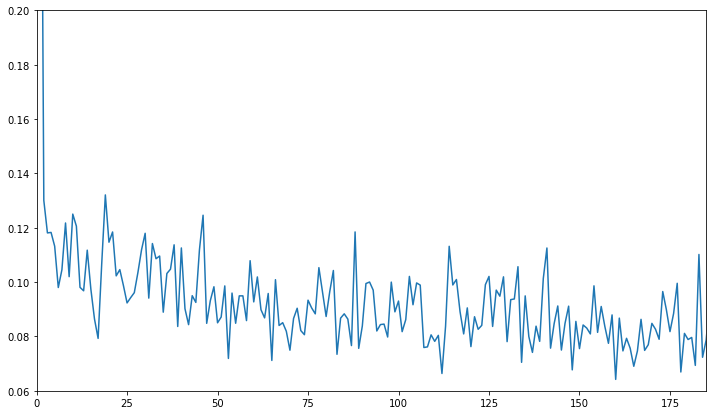

In [110]:
plt.figure(figsize=(12, 7))
plt.plot(losses)
plt.xlim((0,185))
plt.ylim((0.06,0.20))
# plt.savefig('images/erreur.png')

In [87]:
# Tester la prédiction sur un sample particulier
id = 6000
sample = dataset[id]
sample_input = torch.tensor(sample[0])
sample_input = sample_input.to(torch.float32)
sample_input = sample_input.reshape(-1,60,1)
output = model(sample_input)
print(sample[1])
print(output.detach().numpy()[0])

0.7005215123859191
0.62278086


In [92]:
# Test du modèle sur le jeu de donnée test
errors = []
for sample in data_test:
    sample_input = torch.tensor(sample[0])
    sample_input = sample_input.to(torch.float32)
    sample_input = sample_input.reshape(-1,60,1)
    output = model(sample_input).detach().numpy()[0]
    relative_err = min(5,abs((output-sample[1])/sample[1]))
    errors.append(relative_err)
mean_relative_err = np.array(errors).mean()
print(mean_relative_err)

0.18332886210281144


0.01 1e : 0.21
0.001 1e : 0.19
0.0001 1e : 0.24
0.001 2e : 0.17



sw = 30 e2 : 0.183
sw = 60 e2 : 0.183
sw = 120 e2:  0.194
sw = 7 e2 : 0.173
sw = 120 e10 : 0.163
sw = 60 e10 : 0.167

In [111]:
# Taux d'erreur en prenant la dernière valeur connue sur le jeu de données test
errors = []
for sample in data_test:
    output = sample[0][-1]
    relative_err = min(5,abs((output-sample[1])/sample[1]))
    errors.append(relative_err)
mean_relative_err = np.array(errors).mean()
print(mean_relative_err)
print(np.max(errors))

0.22899376934132196
5.0
